## Verifying Exception Cases of OCED PFAS in Merged Dataset

In [2]:
import pandas as pd

with open("/teamspace/studios/this_studio/files/merged_massspec_nist20_mona_fold.tsv", "r") as f:
    df_merged = pd.read_csv(f, sep='\t')

In [3]:
df_merged.head(3)

,smiles,precursor_mz,formula,fold,identifier,mzs,intensities
0,CC(=O)N[C@@H](CC1=CC=CC=C1)C2=CC(=CC(=O)O2)OC,288.1225,C16H17NO4,train,MassSpecGymID0000001,"91.0542,125.0233,154.0499,155.0577,185.0961,20...","0.24524524524524524,1.0,0.08008008008008008,0...."
1,CC(=O)N[C@@H](CC1=CC=CC=C1)C2=CC(=CC(=O)O2)OC,288.1225,C16H17NO4,train,MassSpecGymID0000002,"91.0542,125.0233,155.0577,185.0961,229.0859,24...","0.0990990990990991,0.28128128128128127,0.04004..."
2,CC(=O)N[C@@H](CC1=CC=CC=C1)C2=CC(=CC(=O)O2)OC,288.1225,C16H17NO4,train,MassSpecGymID0000003,"69.0343,91.0542,125.0233,127.039,153.0699,154....","0.03403403403403404,0.31431431431431434,1.0,0...."


In [4]:
from rdkit import Chem
from rdkit.Chem import rdchem

# Definition of PFAS  based on OECD: https://pubs.acs.org/doi/10.1021/acs.est.1c06896
def is_pfas(smiles: str) -> int:
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return 0

        for atom in mol.GetAtoms():
            if atom.GetAtomicNum() != 6:  # carbon only
                continue

            # neighbors
            neigh = atom.GetNeighbors()
            sym = [n.GetSymbol() for n in neigh]

            num_F = sum(1 for s in sym if s == "F")
            has_X  = any(s in ("Cl", "Br", "I") for s in sym)
            has_H  = atom.GetTotalNumHs() > 0  # implicit + explicit Hs

            # require sp3 and all single bonds (rules out alkenes like TFE)
            is_sp3 = atom.GetHybridization() == rdchem.HybridizationType.SP3
            all_single = all(
                mol.GetBondBetweenAtoms(atom.GetIdx(), n.GetIdx()).GetBondType() == rdchem.BondType.SINGLE
                for n in neigh
            )

            # CF3: at least 3 F neighbors; CF2: at least 2 F neighbors
            if (num_F >= 3 or num_F >= 2) and is_sp3 and all_single and not has_H and not has_X:
                # For CF2, make sure there's at least one non-F neighbor so it's truly "-CF2-"
                if num_F >= 3:
                    return 1
                else:  # CF2
                    nonF_neighbors = sum(1 for s in sym if s != "F")
                    if nonF_neighbors >= 1:  # "-CF2-" has something other than F attached
                        return 1

        return 0
    except Exception:
        return 0


In [6]:
df_merged["is_pfas"] = df_merged["smiles"].apply(is_pfas)
pfas_df = df_merged[df_merged["is_pfas"] == 1]
df_train = pfas_df[pfas_df["fold"] == "train"]
print("train PFAS spectra " + str(len(df_train)))
df_val = pfas_df[pfas_df["fold"] == "val"]
print("val PFAS spectra " + str(len(df_val)))

train PFAS spectra 21480
val PFAS spectra 4339


In [7]:
print("train PFAS spectra " + str(df_train["smiles"].nunique()))
print("val PFAS spectra " + str(df_val["smiles"].nunique()))

train PFAS spectra 1464
val PFAS spectra 366


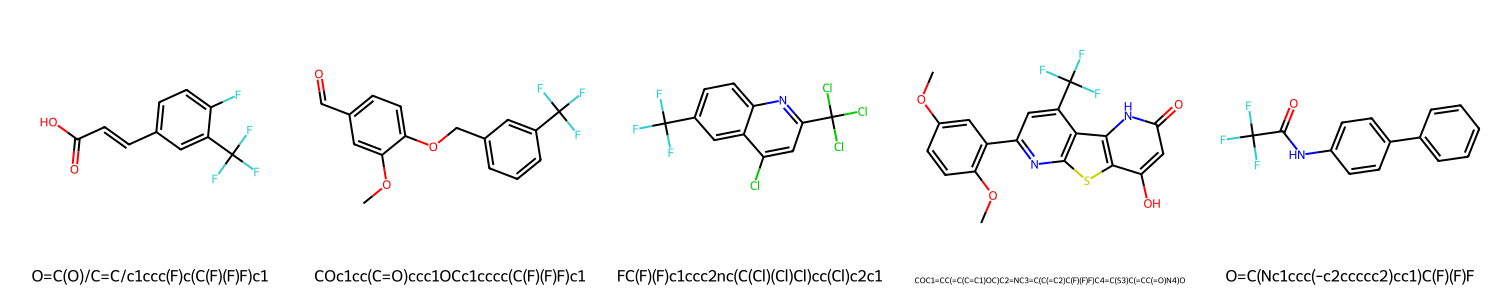

In [58]:
#pfas #1
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw

# Select 10 PFAS molecules at random
pfas_sample = df_merged.loc[df_merged["is_pfas"] == 1, "smiles"].sample(n=50, random_state=42)

# Build dataframe with SMILES + RDKit Mol
pfas_selected = []
for smi in pfas_sample:
    mol = Chem.MolFromSmiles(smi)
    if mol:
        pfas_selected.append({"smiles": smi, "mol": mol})

pfas_df = pd.DataFrame(pfas_selected)

# Function to draw molecules in batches of 5
def draw_batch(df, start_idx, batch_size=5):
    subset = df.iloc[start_idx:start_idx+batch_size]
    mols = subset["mol"].tolist()
    legends = subset["smiles"].tolist()
    return Draw.MolsToGridImage(mols, molsPerRow=batch_size, subImgSize=(300,300), legends=legends)

# Example usage:
img1 = draw_batch(pfas_df, 0)   # first 5
img2 = draw_batch(pfas_df, 5)   # next 5
img3 = draw_batch(pfas_df, 10)
img4 = draw_batch(pfas_df, 49)
img1


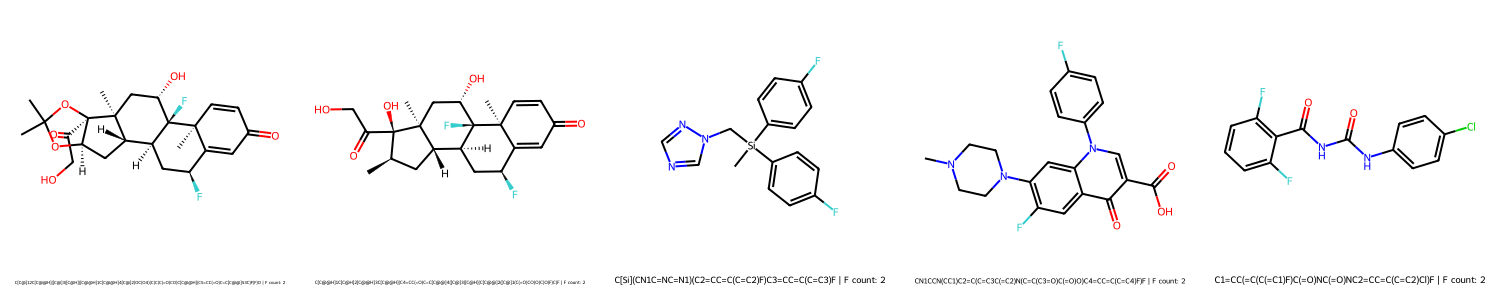

In [57]:
#non-pfas #1
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw

# Filter non-PFAS molecules, remove duplicates
non_pfas = df_merged.loc[df_merged["is_pfas"] == 0, "smiles"].drop_duplicates()

selected = []

for smi in non_pfas:
    mol = Chem.MolFromSmiles(smi)
    if mol:
        # Count fluorine atoms
        fluorine_count = sum(1 for atom in mol.GetAtoms() if atom.GetSymbol() == "F")
        if fluorine_count > 1:
            selected.append({"smiles": smi, "mol": mol, "fluorine_count": fluorine_count})
    if len(selected) == 30:
        break

# Put into a dataframe
selected_df = pd.DataFrame(selected)

# Function to draw 5 molecules at a time
def draw_batch(df, start_idx, batch_size=5):
    subset = df.iloc[start_idx:start_idx+batch_size]
    mols = subset["mol"].tolist()
    legends = [f"{row.smiles} | F count: {row.fluorine_count}" for row in subset.itertuples()]
    return Draw.MolsToGridImage(mols, molsPerRow=batch_size, subImgSize=(300,300), legends=legends)

# Example: draw first batch (5 molecules)
img1 = draw_batch(selected_df, 0)
img2 = draw_batch(selected_df, 5)
img3 = draw_batch(selected_df, 10)
img4 = draw_batch(selected_df, 15)
img1

In [ ]:
img1 = draw_batch(selected_df, 1)
img1